<a href="https://www.kaggle.com/code/clemwo/sales-eda-a-b-testing-predictive-modeling?scriptVersionId=194615986" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter, FuncFormatter

sns.set(style="white")

/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv


<img src="https://seismic.com/wp-content/uploads/2014/09/3-Ways-to-Improve-Sales-Synergy.png" alt="Sales Image" width="800"/>

# 💹 Sales 🤖 EDA, A/B Testing & Predictive Modeling

> In this notebook we are going to work with [Kaggles Clicks Conversion Tracking dataset](https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking/data) which contains data from an anonymous organisation’s social media ad campaign. The objective of this notebook is to perform
>
> - 📊✨ informative and nicely-looking descriptive analysis and EDA
> 
> - 💹🔍 conversion rate, segment, cost efficiency and campaign performance analysis 
> 
> - 🔄🧪 A/B testing 
> 
> - 🤖📈 predictive modeling

In [2]:
sales = pd.read_csv('/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv')
print(f"Rows: {sales.shape[0]:,}")
print(f"Cols: {sales.shape[1]:,}")
print(sales.dtypes)
sales.head(3)

Rows: 1,143
Cols: 11
ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0


The columns are described as follows: 

| Column              | Description                                                                                              |
|:--------------------|:---------------------------------------------------------------------------------------------------------|
| `ad_id`               | A unique ID for each ad.                                                                                 |
| `xyz_campaign_id`     | An ID associated with each ad campaign of XYZ company.                                                   |
| `fb_campaign_id`      | An ID associated with how Facebook tracks each campaign.                                                 |
| `age`                 | Age of the person to whom the ad is shown.                                                               |
| `gender`              | Gender of the person to whom the ad is shown.                                                            |
| `interest`            | A code specifying the category to which the person’s interest belongs (as mentioned in the person’s Facebook public profile). |
| `Impressions`         | The number of times the ad was shown.                                                                    |
| `Clicks`              | Number of clicks on that ad.                                                                             |
| `Spent`               | Amount paid by company XYZ to Facebook to show that ad.                                                  |
| `Total conversion`    | Total number of people who enquired about the product after seeing the ad.                               |
| `Approved conversion` | Total number of people who bought the product after seeing the ad.                                       |


# Descriptive Analysis

In this section we are going to take a look at some summary statistics for the numerical variables. Additionally we are going to investigate the cardinalities of the categorical columnns.

In [3]:
# --- Basic statistics ---
pd.DataFrame(
    {
        'Data Type': sales.dtypes,
        'Missing Count (#)': sales.isnull().sum(),
        'Missing Rate (%)': 100 * sales.isnull().mean(),
        'Unique Count (#)': sales.nunique(),
        'Unique Rate (%)': round(100 * sales.nunique() / sales.shape[0], 2),
        'Duplicates Count (#)': [sales[c].duplicated().sum() for c in sales.columns],
        'Duplicates Rate (%)': [round(100 * sales[c].duplicated().sum() / sales.shape[0], 2) for c in sales.columns],
    }
)

,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
ad_id,int64,0,0.0,1143,100.00,0,0.00
xyz_campaign_id,int64,0,0.0,3,0.26,1140,99.74
fb_campaign_id,int64,0,0.0,691,60.45,452,39.55
age,object,0,0.0,4,0.35,1139,99.65
gender,object,0,0.0,2,0.17,1141,99.83
interest,int64,0,0.0,40,3.50,1103,96.50
Impressions,int64,0,0.0,1130,98.86,13,1.14
Clicks,int64,0,0.0,183,16.01,960,83.99
Spent,float64,0,0.0,869,76.03,274,23.97
Total_Conversion,int64,0,0.0,32,2.80,1111,97.20


- There are no missing values in the dataset 😊. 
- The dataset contains data of __1143 adds__.
- There are only __3 xyz campaigns__ in the dataset.
- There are __691 Facebook campaigns__ in the dataset.
- The customers are segmented into 4 age buckets.

## Numerical Variables

In [4]:
sales_numericals = sales.select_dtypes(include=['int64', 'float64'])

sales_numericals.describe().apply(lambda s: s.apply(lambda x: f"{x:,.2f}"))

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,"1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00"
mean,"987,261.13","1,067.38","133,783.99",32.77,"186,732.13",33.39,51.36,2.86,0.94
std,"193,992.81",121.63,"20,500.31",26.95,"312,762.18",56.89,86.91,4.48,1.74
min,"708,746.00",916.00,"103,916.00",2.00,87.00,0.00,0.00,0.00,0.00
25%,"777,632.50",936.00,"115,716.00",16.00,"6,503.50",1.00,1.48,1.00,0.00
50%,"1,121,185.00","1,178.00","144,549.00",25.00,"51,509.00",8.00,12.37,1.00,1.00
75%,"1,121,804.50","1,178.00","144,657.50",31.00,"221,769.00",37.50,60.02,3.00,1.00
max,"1,314,415.00","1,178.00","179,982.00",114.00,"3,052,003.00",421.00,639.95,60.00,21.00


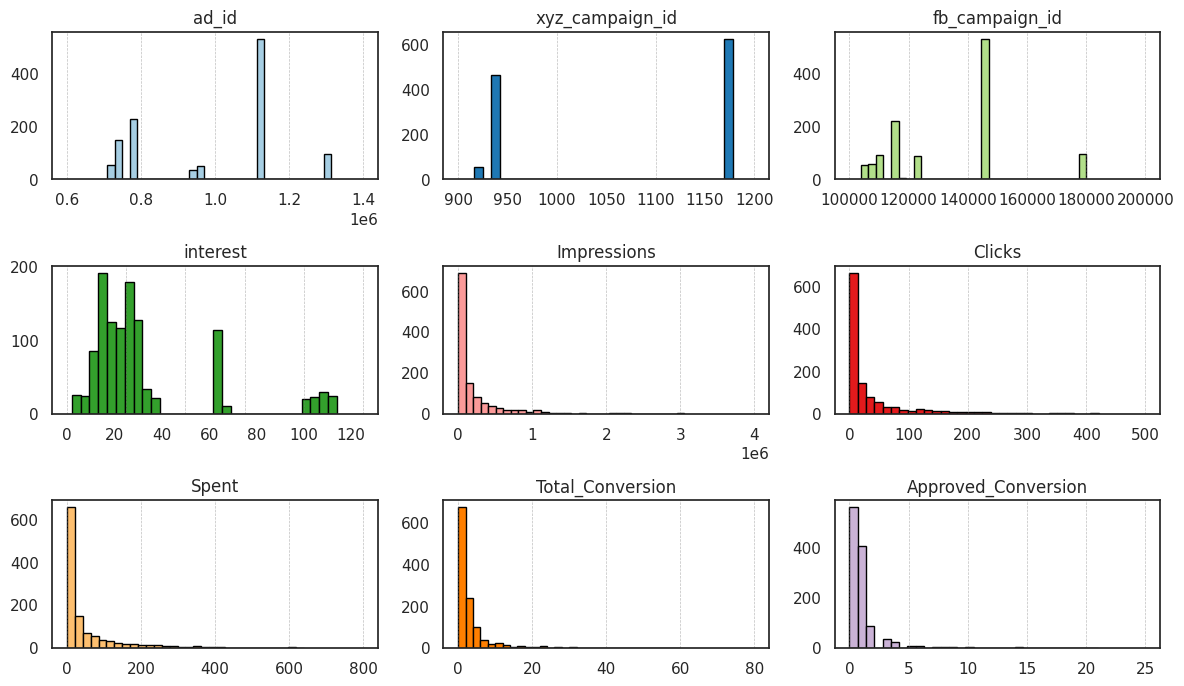

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7))
axes = axes.flatten()

colors = sns.color_palette("Paired", 9)

for i, col in enumerate(sales_numericals):
    ax = axes[i]
    ax.hist(sales[col].dropna(), bins=30, color=colors[i % len(colors)], edgecolor='black')
    ax.set_title(col)
    
    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')    
    
    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)       

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

## Categorical Variables

In [6]:
sales_categoricals = sales.select_dtypes(exclude=['int64', 'float64'])

sales_categoricals.value_counts()

age    gender
30-34  M         229
       F         197
35-39  M         139
45-49  F         138
       M         121
35-39  F         109
40-44  F         107
       M         103
Name: count, dtype: int64

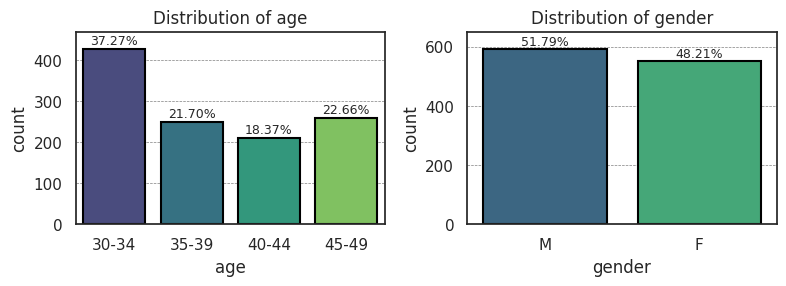

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

for i, col in enumerate(sales_categoricals):
    ax = axes[i]
    
    plot = sns.countplot(data=sales, x=col, 
                         palette='viridis', edgecolor='black', linewidth=1.5, 
                         ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)    
    
    # Add percentage at the top of each bar.
    total = len(sales[col])
    max_height = 0
    for p in plot.patches:
        height = p.get_height()
        max_height = max(max_height, height)
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2., height + 12, 
                f'{percentage:.2f}%', ha='center', fontsize=9)

    ax.set_ylim(0, max_height * 1.10)
    

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

# Exploratory Data Analysis (EDA)

# Conversion Rate Analysis

Let's first clarify some definitions: 

$$
\begin{align}
    \textbf{Click-Through Rate}        &= CTR &&= \frac{\text{Clicks}}{\text{Impressions}} \times 100\%         \quad &\text{Percentage of impressions that resulted in clicks} \\
    \textbf{Total Conversion Rate}     &= CR  &&= \frac{\text{Total_Conversion}}{\text{Clicks}} \times 100\%    \quad &\text{Percentage of clicks that resulted in any conversion} \\
    \textbf{Approved Conversion Rate}  &=     &&= \frac{\text{Approved_Conversion}}{\text{Clicks}} \times 100\% \quad &\text{Percentage of clicks that resulted in approved conversions}\\    
    \textbf{Cost Per Click}            &= CPC &&= \frac{\text{Spent}}{\text{Clicks}}                            \quad &\text{Cost efficiency per click}\\    
    \textbf{Cost Per Conversion}       &=     &&= \frac{\text{Spent}}{\text{Total_Conversion}}                  \quad &\text{Cost efficiency per conversion}
\end{align}
$$

In [8]:
sales['Click_Through_Rate']       = (sales['Clicks'] / sales['Impressions']) * 100
sales['Total_Conversion_Rate']    = (sales['Total_Conversion'] / sales['Clicks']) * 100
sales['Approved_Conversion_Rate'] = (sales['Approved_Conversion'] / sales['Clicks']) * 100
sales['Cost_Per_Click']           = sales['Spent'] / sales['Clicks']                 
sales['Cost_Per_Conversion']      = sales['Spent'] / sales['Total_Conversion'] 

conversion_columns = [
    'Click_Through_Rate', 'Total_Conversion_Rate', 'Approved_Conversion_Rate',
    'Cost_Per_Click', 'Cost_Per_Conversion'
]

sales.head(5)

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.013605,200.0,100.0,1.43,0.715
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.011198,100.0,0.0,0.91,0.910
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,inf,NaN,NaN,0.000
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.023480,100.0,0.0,1.25,1.250
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.024195,100.0,100.0,1.29,1.290


Note that above `1/0=inf` and `0/0=NaN`.

Before we start analysing our data we should be aware of the following: 

- _High CTR_: Indicates that the ad is successful in getting people to click on it.
- _Total Conversion Rate_: Shows the overall effectiveness of turning clicks into any form of conversion.
- _Approved Conversion Rate_: Specifically focuses on conversions that were approved, which might be more critical depending on the campaign goals.
- _CPC and Cost Per Conversion_: Lower values are generally better, indicating cost efficiency in acquiring clicks and conversions.

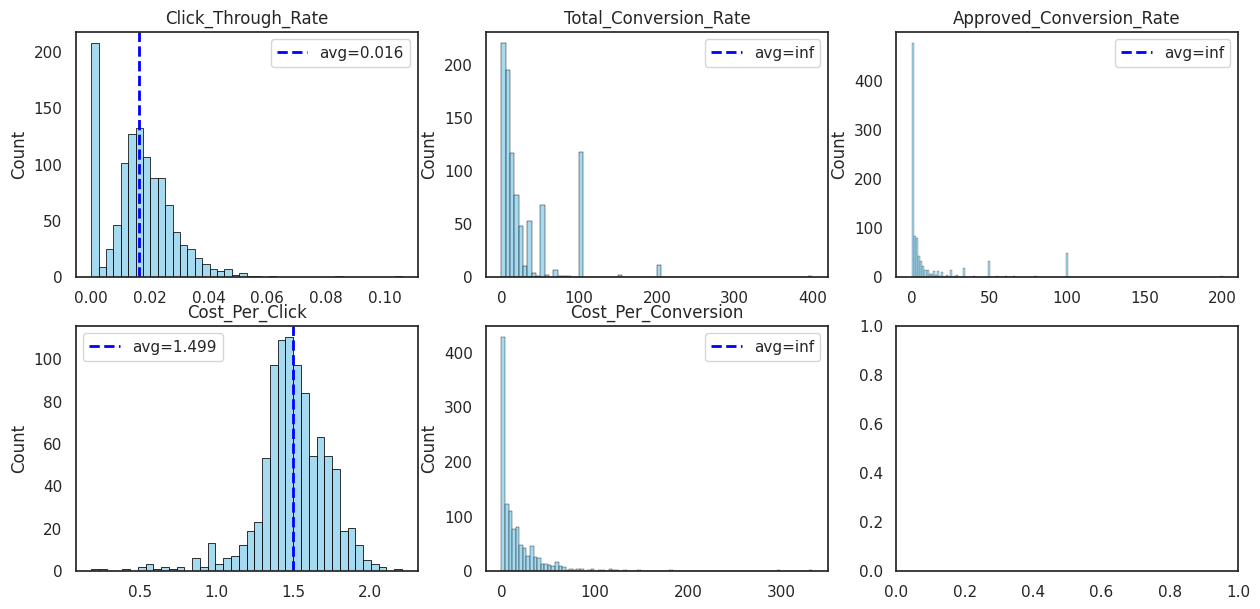

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(conversion_columns):
    sns.histplot(sales, x=col, 
                 color='skyblue', edgecolor='black', ax=axes[i]);
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = sales[col].mean()
    axes[i].axvline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
plt.show()

__Click Through Rate__ (CTR)
- Let's keep in mind that the higher the CTR the better, because then the rate of impressions that resulted in clicks is high.
- The average CTR is are 0.016%. This means that, __on average, 1 click is generated for every 6,250 impressions__. (because 0.016 out of 100 impressions result in a click, and thus, $1/0.00016 \approx 6250$ is how many impressions are needed for 1 click)
- More than 200 ads have a CTR of 0% which indicates that no click at all has been made.

__Total Conversion Rate__ (TCR)
- The distribution is largely left skewed.
- The average TCR is inf. This indicates that, __on average no click resulted in any enquiry (conversion)__.
- There are some adds with have a TCR above 100, which means that the `Total number of people who enquired about the product after seeing the ad` is higher than the `number of people who clicked on that ad`. That can be because a single person who clicked can enquiry more than 1 person. 
- It looks like the maximal TCR is around 400. This indicates that __at least for one ad 4 times more people enquiried the ad compared to clicking on it__.

__Approved Conversion Rate__ (ACR)
- The distribution is even more extremely left skewed than the one of the TCR.
- __Most of the time, no person bought the ad after seeing it__. 

__Cost Per Click__
- The distribution has Gaussian shape.
- On average the cost per click is 1.5.
- The cost per click doesn't fluctuate strongly around the mean.
- The maximal cost per click lies below 2.5. 

__Cost Per Conversion__
- The distribution is highly left skewed.
- At least one ad costs more than 300 for a conversion.

__Summary__

The most interesting findings are: 

> - It takes on average 6,250 impressions to generate a click on an ad.
> 
> - On average no click resulted in any conversion.
> 
> - On average a click costs 1.5. It never costs above 2.5.
> 
> - At least one ad costs more than 300 for a conversion.

# Segment Analysis

In this section we are going to perform segment analysis on the following columns: 

- `Age`: To analyze how different age groups respond to ads in terms of impressions, clicks, and conversions.
- `Gender`: To compare the performance of ads between different genders.
- `Interest`: To evaluate which interest categories have higher conversion rates.

In [10]:
segement_cols_to_analyse = ['Spent', 'Click_Through_Rate', 'Total_Conversion_Rate', 'Approved_Conversion_Rate', 'Cost_Per_Click', 'Cost_Per_Conversion']

## By Age

In [11]:
age_group_analysis = sales.groupby('age').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum'
}).reset_index()

age_group_analysis['Click_Through_Rate']       = (age_group_analysis['Clicks']              / age_group_analysis['Impressions']) * 100
age_group_analysis['Total_Conversion_Rate']    = (age_group_analysis['Total_Conversion']    / age_group_analysis['Clicks'])      * 100
age_group_analysis['Approved_Conversion_Rate'] = (age_group_analysis['Approved_Conversion'] / age_group_analysis['Clicks'])      * 100
age_group_analysis['Cost_Per_Click']           = age_group_analysis['Spent']                / age_group_analysis['Clicks']
age_group_analysis['Cost_Per_Conversion']      = age_group_analysis['Spent']                / age_group_analysis['Total_Conversion']

print("Analysis by Age:")
age_group_analysis

Analysis by Age:


,age,Impressions,Clicks,Total_Conversion,Approved_Conversion,Spent,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,30-34,67993019,9483,1431,494,15252.399986,0.013947,15.090161,5.209322,1.608394,10.658560
1,35-39,42104644,7094,626,207,11112.429994,0.016848,8.824359,2.917959,1.566455,17.751486
2,40-44,39604307,7736,523,170,11589.729981,0.019533,6.760600,2.197518,1.498155,22.160096
3,45-49,63732858,13852,684,208,20750.669997,0.021734,4.937915,1.501588,1.498027,30.337237


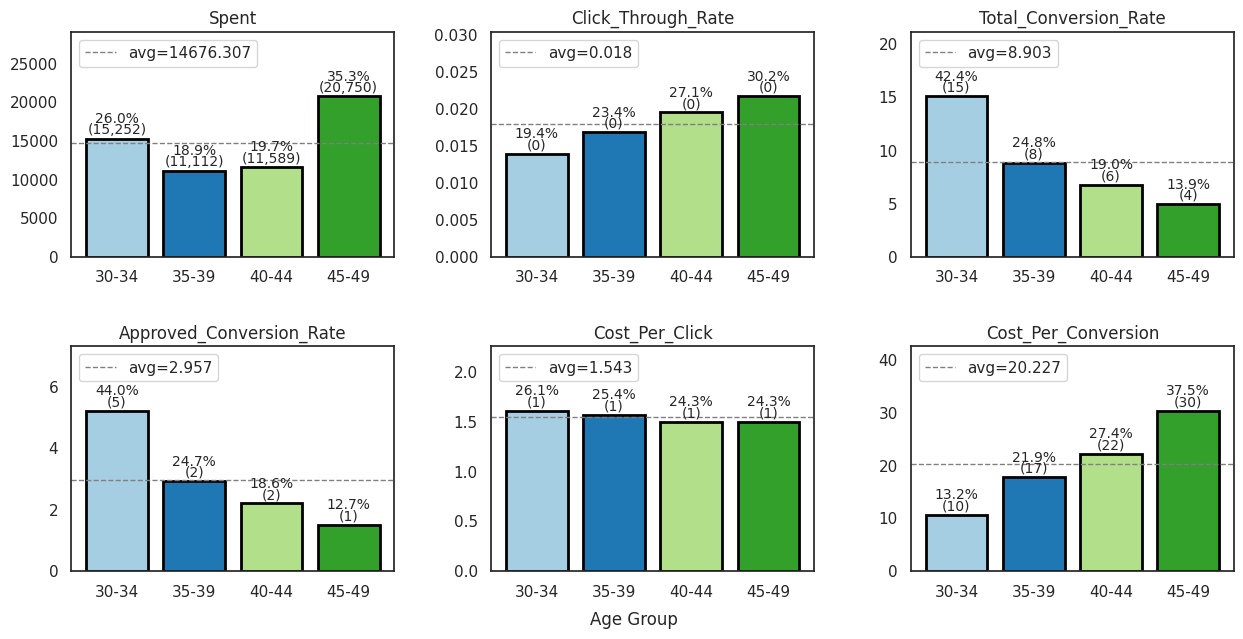

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
colors = plt.cm.Paired(range(len(age_group_analysis)))

for i, col in enumerate(segement_cols_to_analyse):
    
    bars = axes[i].bar(age_group_analysis['age'], age_group_analysis[col], 
                color=colors, edgecolor='black', linewidth=2.0)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    axes[i].set_ylim(0, age_group_analysis[col].max() * 1.4)        
    
    mu = age_group_analysis[col].mean()
    axes[i].axhline(mu, color='grey', linestyle='dashed', 
                    linewidth=1, label=f'avg={mu:0.3f}')
    axes[i].legend(loc='upper left')

    # Show counts and percentages.
    for p in bars:
        height = p.get_height()
        percentage = (height / age_group_analysis[col].sum()) * 100
        
        axes[i].text(p.get_x() + p.get_width() / 2., height + 0.08 * max(age_group_analysis[col]), 
                     f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
        axes[i].text(p.get_x() + p.get_width() / 2., height + 0.01 * max(age_group_analysis[col]), 
                     f'({int(height):,})', ha='center', va='bottom', fontsize=10)

fig.text(0.5, 0.04, 'Age Group', ha='center', va='center', fontsize=12)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()

========== Statistics per age ==========


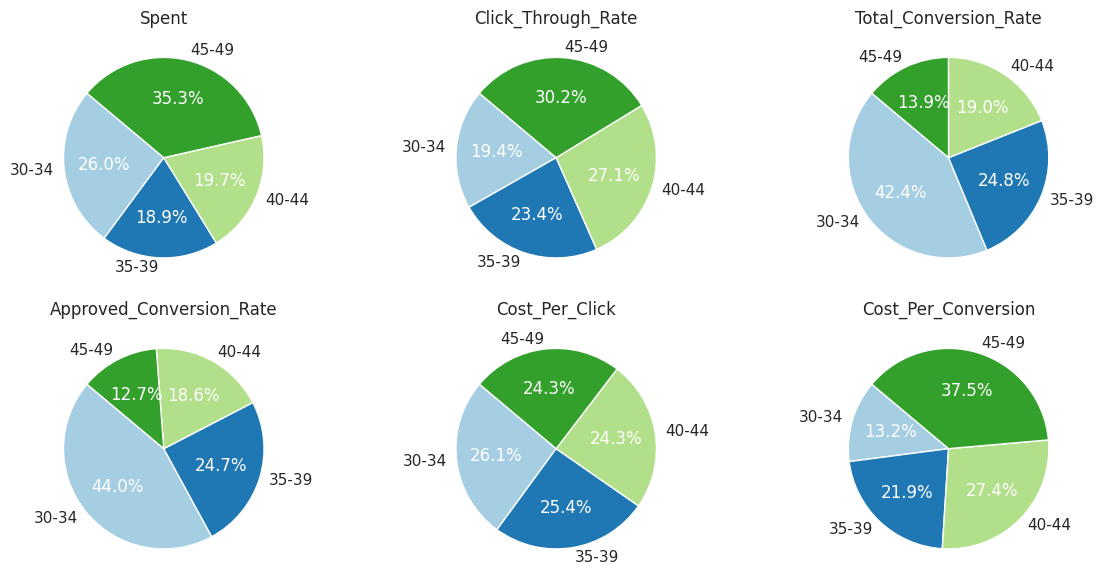

In [13]:
col_to_analyse = 'age'

print(f"{40*'='}")
print(f"{' Statistics per ' + col_to_analyse + ' ':=^40}")
print(f"{40*'='}")

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    wedges, texts, autotexts = axes[i].pie(age_group_analysis[col], 
                                           labels=age_group_analysis['age'], 
                                           colors=colors, 
                                           autopct='%1.1f%%', 
                                           startangle=140)
    axes[i].set_title(f'{col}')
    
    for text in autotexts:
        text.set_color('white')
    
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


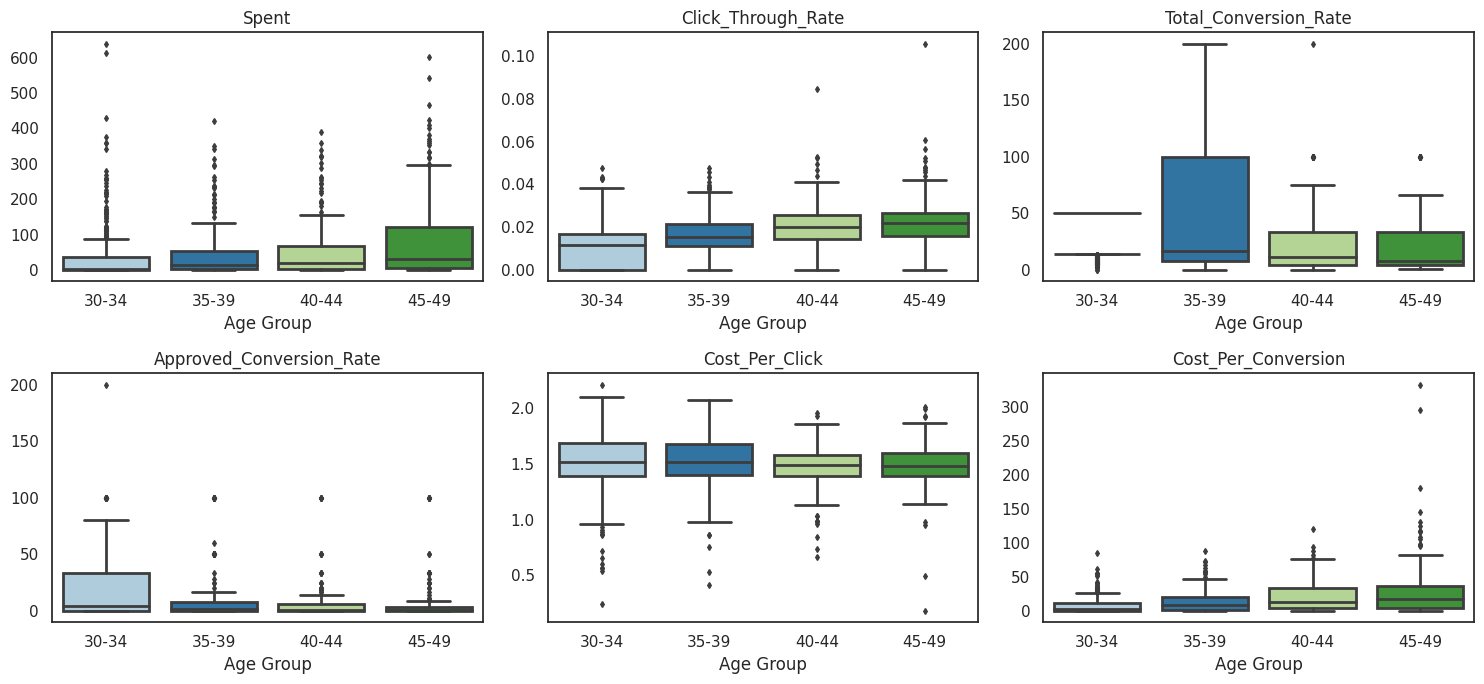

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    
    sns.boxplot(x='age', y=col, data=sales, ax=axes[i], 
                linewidth=2.0, fliersize=3.0, palette="Paired")
    
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel(None)
    
plt.tight_layout()
plt.show()

## By Gender

In [15]:
gender_analysis = sales.groupby('gender').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum'
}).reset_index()

gender_analysis['Click_Through_Rate']       = (gender_analysis['Clicks']              / gender_analysis['Impressions']) * 100
gender_analysis['Total_Conversion_Rate']    = (gender_analysis['Total_Conversion']    / gender_analysis['Clicks'])      * 100
gender_analysis['Approved_Conversion_Rate'] = (gender_analysis['Approved_Conversion'] / gender_analysis['Clicks'])      * 100
gender_analysis['Cost_Per_Click']           = gender_analysis['Spent']                / gender_analysis['Clicks']
gender_analysis['Cost_Per_Conversion']      = gender_analysis['Spent']                / gender_analysis['Total_Conversion']

print("Analysis by Gender:")
gender_analysis

Analysis by Gender:


,gender,Impressions,Clicks,Total_Conversion,Approved_Conversion,Spent,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,F,114862847,23878,1644,495,34502.619963,0.020788,6.884999,2.073038,1.444954,20.986995
1,M,98571981,14287,1620,584,24202.609995,0.014494,11.338979,4.087632,1.694030,14.939883


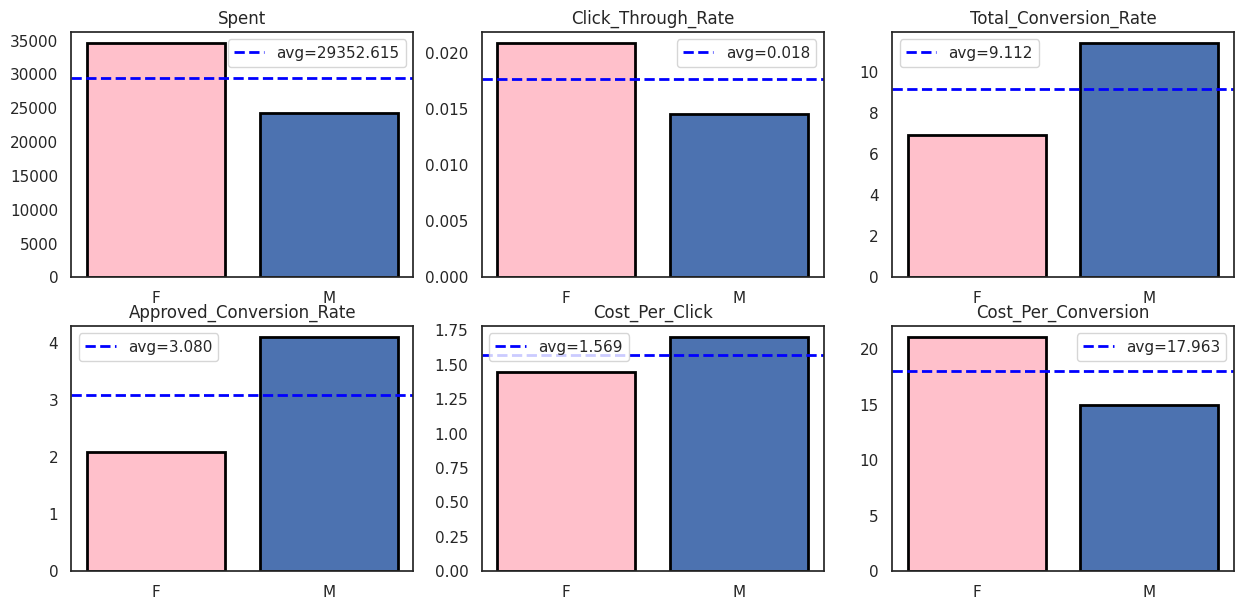

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
colors = ['pink', 'C0']

for i, col in enumerate(segement_cols_to_analyse):
    
    axes[i].bar(gender_analysis['gender'], gender_analysis[col], 
                color=colors, edgecolor='black', linewidth=2.0)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = gender_analysis[col].mean()
    axes[i].axhline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
plt.show()

======== Statistics per gender =========


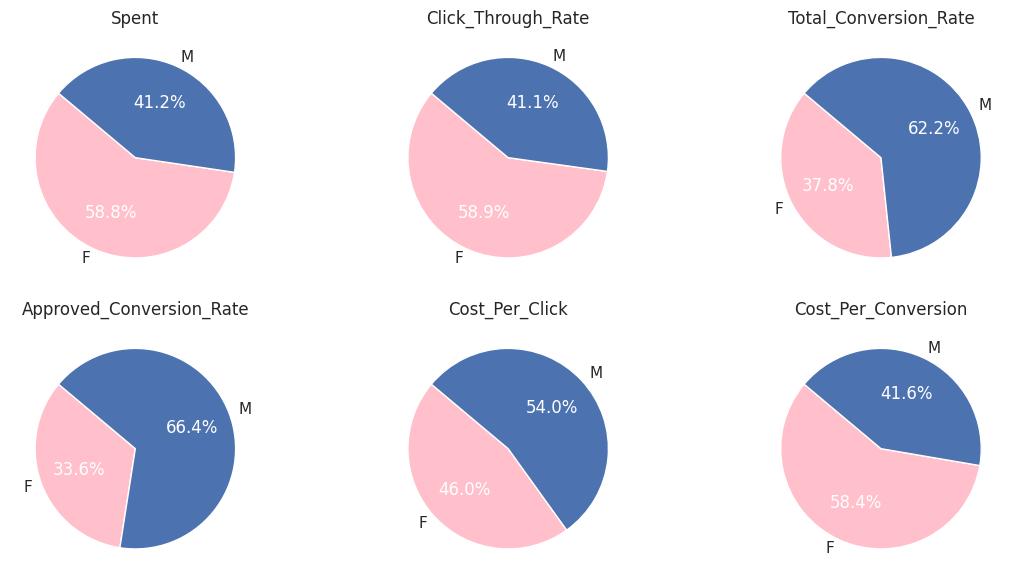

In [17]:
col_to_analyse = 'gender'

print(f"{40*'='}")
print(f"{' Statistics per ' + col_to_analyse + ' ':=^40}")
print(f"{40*'='}")

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    wedges, texts, autotexts = axes[i].pie(gender_analysis[col], 
                                           labels=gender_analysis['gender'], 
                                           colors=colors, 
                                           autopct='%1.1f%%', 
                                           startangle=140)
    axes[i].set_title(f'{col}')
    
    for text in autotexts:
        text.set_color('white')
    
plt.tight_layout()
plt.show()

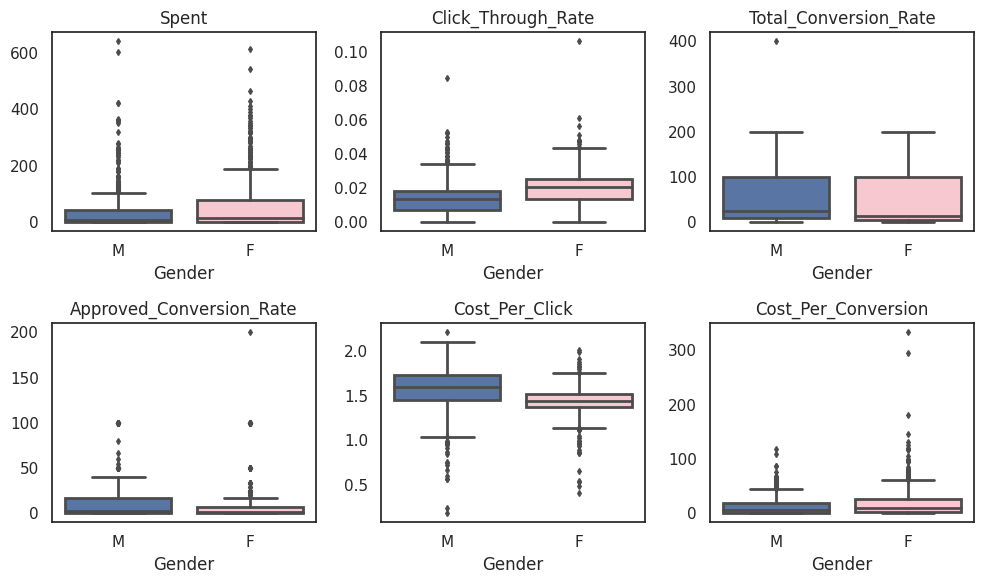

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    
    sns.boxplot(x='gender', y=col, data=sales, ax=axes[i], 
                linewidth=2.0, fliersize=3.0, palette=['C0', 'pink'])
    
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Gender')
    axes[i].set_ylabel(None)
    
plt.tight_layout()
plt.show()

## By Interest

In [19]:
interest_analysis = sales.groupby('interest').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum'
}).reset_index()

interest_analysis['Click_Through_Rate']       = (interest_analysis['Clicks']              / interest_analysis['Impressions']) * 100
interest_analysis['Total_Conversion_Rate']    = (interest_analysis['Total_Conversion']    / interest_analysis['Clicks'])      * 100
interest_analysis['Approved_Conversion_Rate'] = (interest_analysis['Approved_Conversion'] / interest_analysis['Clicks'])      * 100
interest_analysis['Cost_Per_Click']           = interest_analysis['Spent']                / interest_analysis['Clicks']
interest_analysis['Cost_Per_Conversion']      = interest_analysis['Spent']                / interest_analysis['Total_Conversion']

print("Analysis by Interest:")
interest_analysis.head(5)

Analysis by Interest:


,interest,Impressions,Clicks,Total_Conversion,Approved_Conversion,Spent,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,2,1727646,311,40,19,503.450005,0.018001,12.861736,6.109325,1.618810,12.586250
1,7,2612839,410,59,19,648.929999,0.015692,14.390244,4.634146,1.582756,10.998814
2,10,17989844,3317,269,91,5086.379995,0.018438,8.109738,2.743443,1.533428,18.908476
3,15,10745856,1609,195,63,2597.259995,0.014973,12.119329,3.915475,1.614208,13.319282
4,16,31809524,5144,411,141,8084.909990,0.016171,7.989891,2.741058,1.571717,19.671314


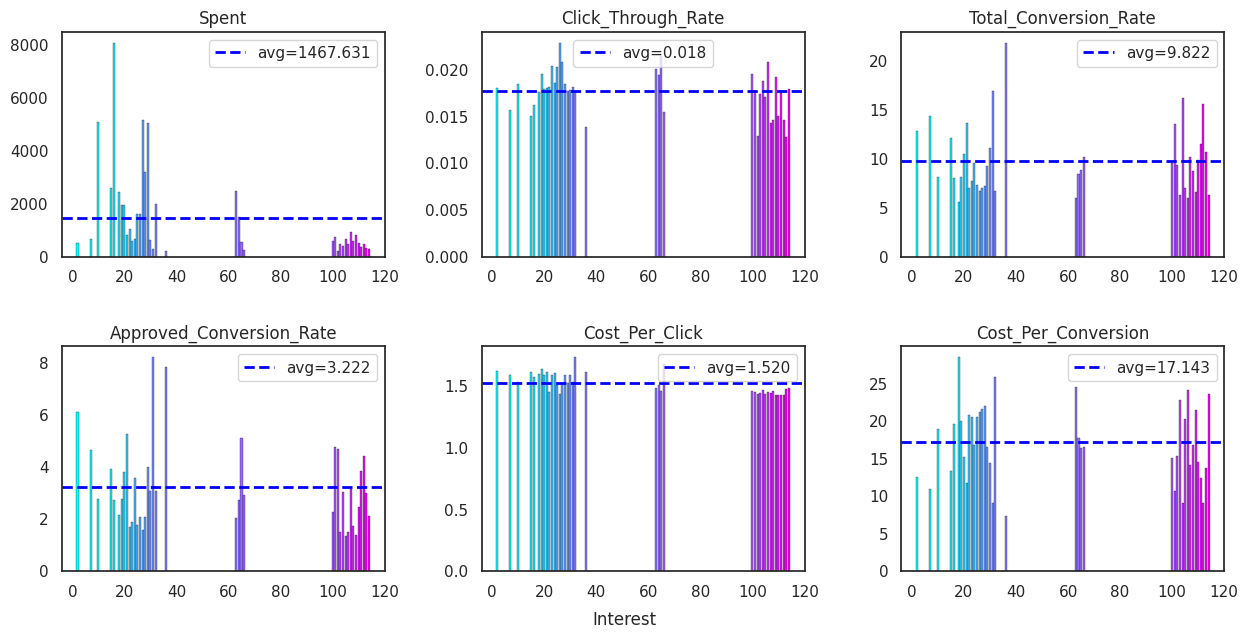

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
colors = plt.cm.cool(np.linspace(0, 1, len(interest_analysis['interest'])))

for i, col in enumerate(segement_cols_to_analyse):
    
    axes[i].bar(interest_analysis['interest'], interest_analysis[col], 
                color=colors, edgecolor='black', linewidth=0.2)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = interest_analysis[col].mean()
    axes[i].axhline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
fig.text(0.5, 0.04, 'Interest', ha='center', va='center', fontsize=12)
fig.subplots_adjust(hspace=0.4, wspace=0.3)    
    
plt.show()

# Campaign Performance Analysis

In this section we are going to investigate the 
- _Ad Campaign Effectiveness_ for which we need to evaluate the effectiveness of different ad campaigns (`xyz_campaign_id`, `fb_campaign_id`) by analyzing their conversion rates and cost efficiency. 
- _Top-Performing Ads_ for which we need to idenitfy ads (based on `ad_id`) that have the highest conversion rates or lowest costs.

In [21]:
sales_subset = sales[sales['Clicks'] > 0]

## Add Campaign Effectiveness

In [22]:
# --------------------------------------------- #
# Investigate the effectivenss of XYZ campaigns #
# --------------------------------------------- #

xyz_campaign_effectiveness = sales_subset.groupby('xyz_campaign_id').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spent': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).reset_index()

# Calculate Conversion Rates and Cost Efficiency.
xyz_campaign_effectiveness['Click_Through_Rate (%)'] = (xyz_campaign_effectiveness['Clicks'] / xyz_campaign_effectiveness['Impressions']) * 100
xyz_campaign_effectiveness['Total_Conversion_Rate (%)'] = (xyz_campaign_effectiveness['Total_Conversion'] / xyz_campaign_effectiveness['Clicks']) * 100
xyz_campaign_effectiveness['Approved_Conversion_Rate (%)'] = (xyz_campaign_effectiveness['Approved_Conversion'] / xyz_campaign_effectiveness['Clicks']) * 100
xyz_campaign_effectiveness['Cost_Per_Click'] = xyz_campaign_effectiveness['Spent'] / xyz_campaign_effectiveness['Clicks']
xyz_campaign_effectiveness['Cost_Per_Conversion'] = xyz_campaign_effectiveness['Spent'] / xyz_campaign_effectiveness['Total_Conversion']

# Sort by effectiveness (e.g., highest Total Conversion Rate).
xyz_campaign_effectiveness = xyz_campaign_effectiveness.sort_values(by='Total_Conversion_Rate (%)', ascending=False)

# Display the results
print("XYZ Campaign Effectiveness")
print("==========================")
print(f"Number of XYZ campaigns: {xyz_campaign_effectiveness.shape[0]:,}")
xyz_campaign_effectiveness.head()

XYZ Campaign Effectiveness
Number of XYZ campaigns: 3


,xyz_campaign_id,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate (%),Total_Conversion_Rate (%),Approved_Conversion_Rate (%),Cost_Per_Click,Cost_Per_Conversion
0,916,448046,113,149.710001,39,16,0.025221,34.513274,14.159292,1.324867,3.838718
1,936,7797942,1984,2893.369999,356,118,0.025443,17.943548,5.947581,1.458352,8.127444
2,1178,204699959,36068,55662.149959,2657,869,0.017620,7.366641,2.409338,1.543256,20.949247


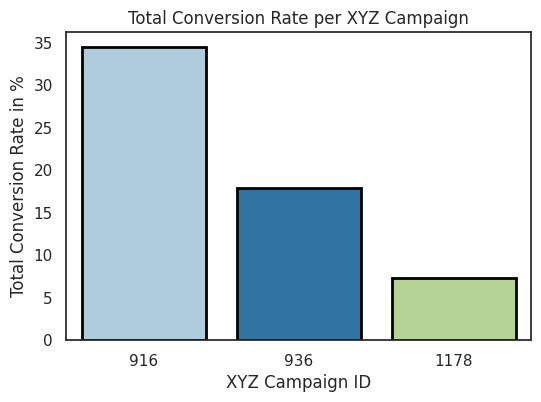

In [23]:
plt.figure(figsize=(6, 4))

sns.barplot(data=xyz_campaign_effectiveness, 
            x='xyz_campaign_id', y='Total_Conversion_Rate (%)', 
            edgecolor='black', linewidth=2.0,
            palette='Paired')
plt.title('Total Conversion Rate per XYZ Campaign')
plt.xlabel('XYZ Campaign ID')
plt.ylabel('Total Conversion Rate in %')

plt.show()

In [24]:
# -------------------------------------------------- #
# Investigate the effectivenss of Facebook campaigns #
# -------------------------------------------------- #

fb_campaign_effectiveness = sales_subset.groupby('fb_campaign_id').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spent': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).reset_index()

# Calculate Conversion Rates and Cost Efficiency.
fb_campaign_effectiveness['Click_Through_Rate (%)'] = (fb_campaign_effectiveness['Clicks'] / fb_campaign_effectiveness['Impressions']) * 100
fb_campaign_effectiveness['Total_Conversion_Rate (%)'] = (fb_campaign_effectiveness['Total_Conversion'] / fb_campaign_effectiveness['Clicks']) * 100
fb_campaign_effectiveness['Approved_Conversion_Rate (%)'] = (fb_campaign_effectiveness['Approved_Conversion'] / fb_campaign_effectiveness['Clicks']) * 100
fb_campaign_effectiveness['Cost_Per_Click'] = fb_campaign_effectiveness['Spent'] / fb_campaign_effectiveness['Clicks']
fb_campaign_effectiveness['Cost_Per_Conversion'] = fb_campaign_effectiveness['Spent'] / fb_campaign_effectiveness['Total_Conversion']

# Sort by effectiveness (e.g., highest Total Conversion Rate).
fb_campaign_effectiveness = fb_campaign_effectiveness.sort_values(by='Total_Conversion_Rate (%)', ascending=False)

print("Facebook Campaign Effectiveness")
print("===============================")
print(f"Number of Facebook campaigns: {fb_campaign_effectiveness.shape[0]:,}")
fb_campaign_effectiveness.head()

Facebook Campaign Effectiveness
Number of Facebook campaigns: 543


,fb_campaign_id,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate (%),Total_Conversion_Rate (%),Approved_Conversion_Rate (%),Cost_Per_Click,Cost_Per_Conversion
35,108668,5374,1,1.04,4,0,0.018608,400.0,0.0,1.04,0.260
0,103916,7350,1,1.43,2,1,0.013605,200.0,100.0,1.43,0.715
157,115737,5209,1,0.96,2,0,0.019198,200.0,0.0,0.96,0.480
196,116220,6175,1,1.37,2,1,0.016194,200.0,100.0,1.37,0.685
238,123481,6607,1,1.32,2,0,0.015135,200.0,0.0,1.32,0.660


## Top-Performing Ads

In [25]:
ad_effectiveness = sales_subset.groupby('ad_id').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spent': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).reset_index()

# Calculate Conversion Rates and Cost Efficiency.
ad_effectiveness['Click_Through_Rate (%)'] = (ad_effectiveness['Clicks'] / ad_effectiveness['Impressions']) * 100
ad_effectiveness['Total_Conversion_Rate (%)'] = (ad_effectiveness['Total_Conversion'] / ad_effectiveness['Clicks']) * 100
ad_effectiveness['Approved_Conversion_Rate (%)'] = (ad_effectiveness['Approved_Conversion'] / ad_effectiveness['Clicks']) * 100
ad_effectiveness['Cost_Per_Click'] = ad_effectiveness['Spent'] / ad_effectiveness['Clicks']
ad_effectiveness['Cost_Per_Conversion'] = ad_effectiveness['Spent'] / ad_effectiveness['Total_Conversion']

# Top-performing ads by conversion rate.
top_conversion_ads = ad_effectiveness.sort_values(by='Total_Conversion_Rate (%)', ascending=False).head(10)

# Top-performing ads by lowest cost per conversion.
lowest_cost_ads = ad_effectiveness.sort_values(by='Cost_Per_Conversion', ascending=True).head(10)

In [26]:
print("Top-Performing Ads by Conversion Rate")
print(f"Number of ads: {top_conversion_ads.shape[0]}")

avg_total_cr = sales_subset['Total_Conversion_Rate'].mean()
print(f"Note that the average Total Conversion Rate is {avg_total_cr:0.2f} %")

top_conversion_ads['% Higher Than Average'] = round(100 * (top_conversion_ads['Total_Conversion_Rate (%)'] / avg_total_cr), 2)

top_conversion_ads[['ad_id', 'Total_Conversion_Rate (%)', '% Higher Than Average']]

Top-Performing Ads by Conversion Rate
Number of ads: 10
Note that the average Total Conversion Rate is 29.52 %


,ad_id,Total_Conversion_Rate (%),% Higher Than Average
37,734290,400.0,1355.23
0,708746,200.0,677.62
352,1121129,200.0,677.62
236,780511,200.0,677.62
289,950326,200.0,677.62
219,779622,200.0,677.62
32,711623,200.0,677.62
305,951391,200.0,677.62
330,1121101,200.0,677.62
334,1121107,200.0,677.62


- The Ad with the highest total CR has a total CR which is __more then 13 times higher than the average CR__.
- All the other top 10 Ads have a more than 6 times higher CR than the average CR.

In [27]:
print("Top-Performing Ads by Lowest Cost Per Conversion")
print(f"Number of ads: {lowest_cost_ads.shape[0]}")

average_cost_per_conversion = sales_subset[sales_subset['Cost_Per_Conversion'] != np.inf]['Cost_Per_Conversion'].mean()
print(f"Note that the average Cost Per Conversion is {average_cost_per_conversion:0.2f}")

# How much percent lower are the top lowest cost ads compared to the avergae cost of ads?
lowest_cost_ads['% Lower Than Average'] = 100 * (average_cost_per_conversion - lowest_cost_ads['Cost_Per_Conversion']) / average_cost_per_conversion

lowest_cost_ads[['ad_id', 'Cost_Per_Conversion', '% Lower Than Average']]

Top-Performing Ads by Lowest Cost Per Conversion
Number of ads: 10
Note that the average Cost Per Conversion is 19.66


,ad_id,Cost_Per_Conversion,% Lower Than Average
174,777105,0.180,99.084618
69,736869,0.240,98.779491
37,734290,0.260,98.677782
94,747223,0.300,98.474363
315,951756,0.410,97.914963
219,779622,0.445,97.736972
189,777758,0.480,97.558981
134,776416,0.490,97.508127
258,781354,0.530,97.304709
78,737931,0.540,97.253854


# A/B Testing Analysis

We can only "simulate" A/B testing for the given dataset. This is because A/B testing usually involves comparing two or more versions of the same element (e.g., different ad creatives or messages) shown to similar audience segments. Our dataset doesn't explicitly show different variants of a single campaign, but rather different ads and campaigns.

Also, since the dataset involves multiple campaigns with potentially different audience segments (e.g., `age`, `gender`, `interest`), impressions, and other variables, it's hard to isolate the effect of a single variable (like a campaign variation) without considering the impact of other factors.

So, true A/B testing would involve:
- Same Audience: Splitting the same audience randomly into two or more groups.
- Controlled Variations: Showing each group a different version of the ad (e.g., different creative, messaging) while keeping all other variables constant.
- Direct Comparison: Measuring which version performs better in terms of conversions, clicks, or another specific metric.

Also, normally we would perform the following steps: 

1. Define Hypotheses: What are you testing for?
2. Randomization: Ensure users are randomly assigned to groups.
3. Run Experiment: Gather data.
4. Calculate Metrics: Such as conversion rates.
5. Statistical Testing: Use a suitable test (e.g., z-test) to determine significance.
6. Conclusions: Make a decision based on the statistical test results.

What we can do though is to group ads by similar characteristics (same `age` range, `gender`, and `interest`) and then compare how different campaigns (`xyz_campaign_id` or `fb_campaign_id`) perform within these groups.

In [28]:
# ---------------- #
# Prepare the data #
# ---------------- #

campaign_ids = [916, 936, 1178]

# Filter the campaigns.
df_campaigns = sales[sales['xyz_campaign_id'].isin(campaign_ids)]

# Aggregate per campaign.
summary_campaigns = df_campaigns.groupby('xyz_campaign_id').agg({
    'Clicks': 'sum',
    'Impressions': 'sum',
    'Total_Conversion': 'sum'
}).reset_index()


summary_campaigns['Conversion Rate'] = summary_campaigns['Total_Conversion'] / summary_campaigns['Clicks']

print("Summary of Campaigns:")
summary_campaigns

Summary of Campaigns:


,xyz_campaign_id,Clicks,Impressions,Total_Conversion,Conversion Rate
0,916,113,482925,58,0.513274
1,936,1984,8128187,537,0.270665
2,1178,36068,204823716,2669,0.073999


In [29]:
# ----------------------- #
# Conduct Chi-Square Test #
# ----------------------- #

from scipy.stats import chi2_contingency

# Create contingency table.
contingency_table = pd.crosstab(df_campaigns['xyz_campaign_id'], df_campaigns['Total_Conversion'])

# Perform Chi-Square test.
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

Chi-Square Statistic: 368.5843
P-Value: 0.0000


In [30]:
# ----------------- #
# Interpret p-value #
# ----------------- #

ALPHA = 0.05

if p_value < ALPHA:
    print("Reject the null hypothesis. There is a significant difference in conversion rates among the campaigns.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in conversion rates among the campaigns.")

Reject the null hypothesis. There is a significant difference in conversion rates among the campaigns.


# Predictive Modeling

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏